In my [last post](http://zhoujli.github.io/2016-03-10-Spark-I/) I briefly introduce how I set up Apache Spark on my own laptop. In this post, I will start using Spark and Python to do some data exploration.

## Resilient Distributed Datasets
Let's first get familiar with how Spark store data. The Resilient Distributed Datasets (RDD) is the core concept of Spark. An RDD is a collection of "records" that is distributed or partitioned across many nodes in a cluster.

The RDD is fault-tolerant, which means if a given node or task fails, it can be reconstructed automatically on the remaining nodes and the job will still complete.

## Data

The dataset I will use is called **MovieLens 100k** (it can be downloaded [here](http://grouplens.org/datasets/movielens/)). It contains 100,000 data points related to ratings given by a set of users to a set of movies. It also contains movie metadata and user profiles. It is applicable to recommender systems as well as potentially other machine learning tasks. Therefore it serves as a useful example.

Examples of other publicly accessible datasets include

* [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.html)
* [Amazon AWS Public Data Sets](http://aws.amazon.com/public-data-sets/)
* [Kaggle](https://www.kaggle.com/competitions)
* [KDnuggets](http://www.kdnuggets.com/datasets/index.html)

## Exploring the user data

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd

In [2]:
user = sc.textFile("E:/Documents/zhoujli.github.io/_source/ml-100k/u.user")

Let's first take a look at the user information. The `take(k)` function collects the first *k* elements of the RDD to the driver. If you are familiar with `pandas`, it is very similar to the `head` function.

In [3]:
user.take(5)

[u'1|24|M|technician|85711',
 u'2|53|F|other|94043',
 u'3|23|M|writer|32067',
 u'4|24|M|technician|43537',
 u'5|33|F|other|15213']

We can see that each line of the data is a combination of several fields of user information (user ID, age, gender, occupation and ZIP codes), separated by the "\|" character. The next step is to split them. The `map` operator applies a self-defined function to each record of an RDD, thus mapping the input to some new output. In Python, it is easy to define a function using `lambda`.

In [4]:
user_fields = user.map(lambda line: line.split("|"))
user_fields.first()

[u'1', u'24', u'M', u'technician', u'85711']

After the fields are seperated, we can start playing around with the data. We may ask questions like below.

* How many unique users?
* How many unique genders?
* How many unique jobs?
* How many unique ZIP codes?

It is easy to answer the above questions using the `distinct` and `count` functions.

In [5]:
num_users = user_fields.map(lambda fields: fields[0]).distinct().count()
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count()
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count()

print "Users: %d, genders: %d, occupations: %d, ZIP codes: %d" % (num_users, num_genders, num_occupations, num_zipcodes)

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


We can also visualize the distribution of user ages. Here I am using the `distplot` function provided by [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/).

As we can see, the age distribution is right-skewed (with long tail on the right). A large number of users are around 15~35.

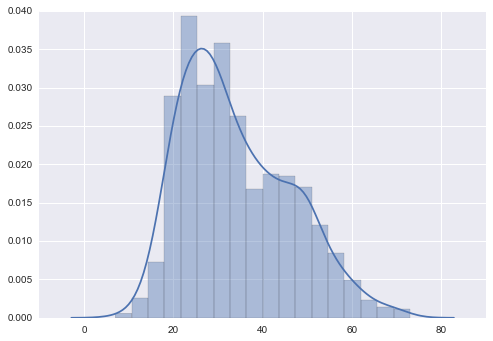

In [6]:
ages = user_fields.map(lambda x: int(x[1])).collect()

sns.distplot(ages)

What if we want to know number of users by their occupations? 

We can first `map` each user's occupation to a (key, value) pair, where key is occupation and value is 1. For example, ('student', 1).

Then, the `reduceByKey` function will merge the values for each key using an associative reduce function. This will also perform the merging locally on each mapper before sending results to a reducer, similarly to a “combiner” in MapReduce.

Finally, we collect the output and save it in a pandas DataFrame, sort by count, and plot it.

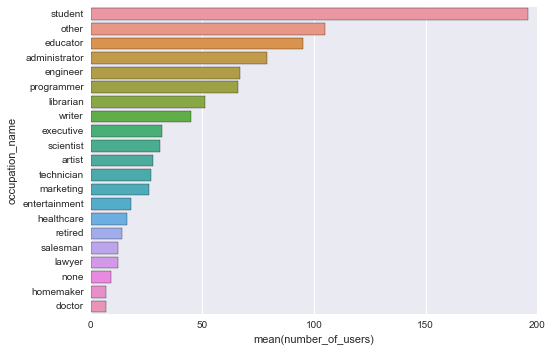

In [7]:
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
c_by_o = pd.DataFrame(count_by_occupation, columns=['occupation_name', 'number_of_users']).sort_values('number_of_users', ascending=False)
sns.barplot(x='number_of_users', y='occupation_name', data=c_by_o)